# Performance Evaluation Metrics beyond Accuracy

While we generally use prediction accuracy to evaluate a model's performance, there are many other metrics which can be more useful, such as *F1 score* and the *Matthews correlation coefficient*.

### Confusion Matrices

For now, let's take a look at the *confusion matrix*, which allows us to visualize how a classification algorithm performs. The confusion matrix is a square matrix which counts the true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions of a classifier. The sklearn library provides a `confusion_matrix` class to allow us to easily calculate the confusion matrix for a classifier:

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#import dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
    header=None)

#create numpy arrays
X = df.loc[:, 2:].values
y = df.loc[:, 1]

#encode class labels, M is 1 and B is 0
le = LabelEncoder()
y = le.fit_transform(y)

#perform 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#make SVC pipeline and fit to data
pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=42))
pipe_svc.fit(X_train, y_train)

#now evaluate on test set and create confusion matrix
y_pred = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_mat)

[[72  0]
 [ 3 39]]


Now we create an illustration of this confusion matrix using matplotlib.

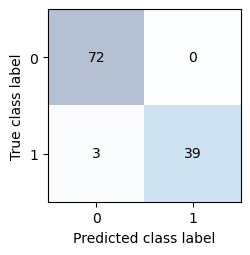

In [4]:
import matplotlib.pyplot as plt

#create four subplots
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted class label')
plt.ylabel('True class label')
plt.show()

We know that class $1$ (malignant) is the positive class, so in the above we see that our model correctly classified $72$ instances that belong to the negative class (TN), and $40$ examples that belong to the positive class (TP). However, our model also incorrectly classified three instances as belonging to the negative class, when in reality they belong to the positive class (FN).

### Optimizing Precision and Recall

Both the prediction error $\text{ERR}$ and accuracy $\text{ACC}$ provide general information about the performance of a classifier. We can calculate these metrics as follows:
$$
\text{ERR} = \frac{\text{FP}+\text{FN}}{\text{FP}+\text{FN}+\text{TP}+\text{TN}}, \\
\text{ACC} = \frac{\text{TP}+\text{TN}}{\text{FP}+\text{FN}+\text{TP}+\text{TN}} = 1-\text{ERR}.
$$
The true positive rate (TPR) and false positive rate (FPR) are metrics that are especially useful for imbalanced class problems:
$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+\text{TN}}, \\
\text{TPR} = \frac{\text{TP}}{\text{FN}+\text{TP}}.
$$

The performance metric recall ($\text{REC}$) is synonymous with TPR, and it provides information about the fraction of positive examples that were identifed correctly out of the entire pool of positive instances:
$$
\text{REC} = \text{TPR} = \frac{\text{TP}}{\text{FN}+\text{TP}}.
$$

In contrast, precision ($\text{PRE}$) quantifies how many of the instances predicted to be positive are actually positive:
$$
\text{PRE} = \frac{\text{TP}}{\text{TP}+\text{FP}}.
$$

To balance optimizing for both precision and recall, we use the harmonic mean of the two metrics, which we call the F1 score:
$$
\text{F1} = 2\left(\frac{\text{PRE}\cdot\text{REC}}{\text{PRE} + \text{REC}}\right).
$$

A final measure that summarizes the confusion matrix is the Matthews correlation coefficient (MCC), which takes all elements of the confusion matrix into account (for example, F1 score does not include the TN). Also, MCC ranges between $-1$ and $1$, so it may be harder to interpret, but it is regarded as a superior metric to the F1 score. We calculate it as follows:
$$
\text{MCC} = \frac{\text{TP}\cdot\text{TN} - \text{FP}\cdot\text{FN}}{\sqrt{(\text{TP}+\text{FP})(\text{TP}+\text{FN})(\text{TN}+\text{FP})(\text{TN}+\text{FN})}}.
$$

All of these scoring metrics can be implemented with sklearn:

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

#print value of each metric for the classifier above
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print("Precision: {}".format(pre_val.round(3)))

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print("Recall: {}".format(rec_val.round(3)))

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print("F1: {}".format(f1_val.round(3)))

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print("MCC: {}".format(mcc_val.round(3)))

Precision: 1.0
Recall: 0.929
F1: 0.963
MCC: 0.944


We can also use one of these scoring metrics with the `GridSearchCV` function. A complete list of different values accepted by the scoring parameter is available at <http://scikit-learn.org/stable/modules/model_evaluation.html>.

### Plotting Receiver Operating Characteristic

Receiver operating characteristic (ROC) curve are useful tools to select models for classification based on their performance with respect to TPR and FPR, which are computed by shifting the decision threshold of the classifier. The diagonal of an ROC graph can be interpreted as random guessing, and classification models that fall below this diagonal are worse than random guessing. A perfect classifier would fall in the top left of the graph, with a TPR of $1$ and an FPR of $0$. Based on the ROC curve, we can then compute the ROC area under the curve (ROC AUC) to characterize the performance of a classification model.

Similar to ROC curves, we can also plot precision-recall curves for different probability thresholds of a classifier. This is also implemented in sklearn at <http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html>.

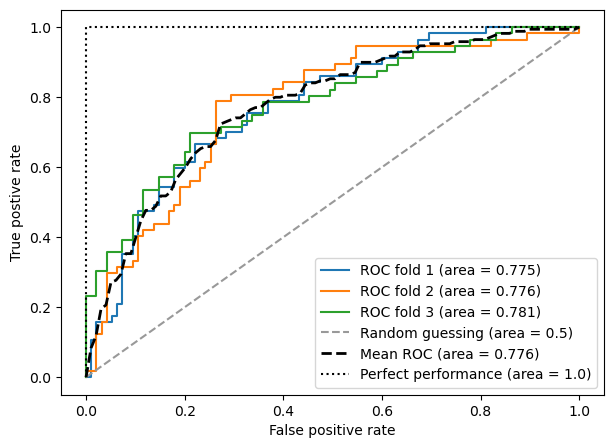

In [11]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.model_selection import StratifiedKFold
import numpy as np

#make a logistic regression pipeline with PCA for dimensionality reduction
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2', random_state=42,
                                         solver='lbfgs', C=100.0))

#make new dataset with only two features, worse performance will make ROC curves more interesting
X_train2 = X_train[:, [4, 14]]

#perform 3-fold CV
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

#set up plots
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

#plot performance of lr pipeline on each of the folds
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(
        X_train2[train],
        y_train[train]
    ).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold {num} (area = {roc_auc})'.format(num=i+1, roc_auc=roc_auc.round(3)))

#plot random guessing curve
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing (area = 0.5)')

#plot mean of lr pipeline curves
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = {})'.format(mean_auc.round(3)), lw=2)

#plot perfect performance curve
plt.plot([0, 0, 1],
        [0, 1, 1],
        linestyle=':',
        color='black',
        label='Perfect performance (area = 1.0)')

#finalize plot information
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True postive rate')
plt.legend(loc='lower right')
plt.show()

If we are just interested in the ROC AUC score, then we can simply import the `roc_auc_score` function from the `sklearn.metrics` submodule, which can be used similarly to the other scoring functions introduced above.

# Scoring Metrics for Multiclass Classification

COME BACK TO THIS LATER, NOT RELEVANT FOR BINARY CLASSIFICATION
AT THE SAME TIME LOOK AT THE make_scorer FUNCTION DESCRIBED EARLIER

# Dealing with Class Imbalance

Suppose the majority class has many more instances than the minority class, say, in a $9:1$ ratio. Then a classifier which always predicts the majority (usually, negative) class will achieve $90\%$ prediction accuracy. So, when evaluating a model on such a dataset, it makes sense to use one of the metrics specified above rather than accuracy.

However, class imbalance also affects a learning algorithm during the model fitting process. Since machine learning algorithms typically optimize a reward or loss function that is computed as a sum over all training examples, the decision rule is likely to be biased in favor of the majority class.

One way to deal with class imbalance is to assign a larger penalty to wrong predictions of instances in the minority class. We can implement this in sklearn by simply including the parameter `class_weight=balanced`, which is available for most classifiers.

Other popular strategies include upsampling the minority class, downsampling the majority class, and generating synthetic training examples. An example of how to upsample the minority class is given below; it will repeatedly draw new samples from the minority class until it contains the same number of examples as the majority class.

In [15]:
from sklearn.utils import resample

print('Number of class 1 examples before: {}'.format(X_train[y_train==1].shape[0]))
X_upsampled, y_upsampled = resample(
    X_train[y_train==1],
    y_train[y_train==1],
    replace=True,
    n_samples=X_train[y_train==0].shape[0],
    random_state=42
)
print('Number of class 1 examples after: {}'.format(X_upsampled[y_upsampled==1].shape[0]))

Number of class 1 examples before: 170
Number of class 1 examples after: 285


To generate synthetic training examples in the minority class, the most popular method is Synthetic Minority Over-sampling Technique (SMOTE), which one can learn more about in the original research paper available here: <https://www.jair.org/index.php/jair/article/view/10302>. To find an implementation of SMOTE in Python, as well as multiple other functions dedicated to working with imbalanced datasets, the library imbalanced-learn is extremely helpful: <https://github.com/scikit-learn-contrib/imbalanced-learn>.